In [3]:
 # Zelle 1: Importiere benötigte Bibliotheken und richte das Gerät ein
# Für Text-Embeddings direkt mit Hugging Face Transformers
from transformers import AutoTokenizer, AutoModel, CLIPProcessor, CLIPModel

# Für numerische Berechnungen und Visualisierung
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
from datasets import load_from_disk

# Cuda verwenden da es schneller ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwende Gerät: {device}")


Verwende Gerät: cuda


In [4]:
# Zelle 2: Initialisiere BERT für Text und CLIP für Bild-Embeddings

# BERT-Modell und Tokenizer für Text-Embeddings
model_name_text = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_text)
text_model = AutoModel.from_pretrained(model_name_text)
text_model.to(device)  # Modell auf das Gerät verschieben

# CLIP-Modell und -Prozessor für Bild-Embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.to(device)  # CLIP-Modell ebenfalls auf das Gerät verschieben


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [5]:
# Zelle 3: Funktionen zur Berechnung der Embeddings

def get_text_embedding(text):
    """
    Erzeugt ein Text-Embedding für einen gegebenen Text mittels BERT.
    Wir nutzen Mean-Pooling über die letzten Hidden States.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()} 
    with torch.no_grad():
        outputs = text_model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze(0).cpu() 
    mean_embedding = embeddings.mean(dim=0).numpy()
    return mean_embedding

def get_image_embedding(image):
    """
    Erzeugt ein Bild-Embedding mithilfe des CLIP-Modells.
    """
    inputs = clip_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()} 
    with torch.no_grad():
        image_emb = clip_model.get_image_features(**inputs)
    image_emb = image_emb.squeeze().cpu().numpy() 
    return image_emb


In [6]:
# Zelle 4: Funktion, die Text- und Bild-Embeddings kombiniert

def get_combined_embedding(sample):
    """
    Erzeugt einen kombinierten Feature-Vektor aus der Frage (Text) und dem Bild.
    Die beiden Embeddings werden hier mittels Concatenation zusammengeführt.
    """
    text_emb = get_text_embedding(sample["question"])
    image_emb = get_image_embedding(sample["image"])
    combined_embedding = np.concatenate([text_emb, image_emb])
    return combined_embedding


In [7]:
# Zelle 5: Definiere die sequenzielle Auswahl (SelfDis) aus dem basierenden Paper das vorgestellt wurde

def sequential_selfdis_selection(dataset, M):
    """
    Wählt M Beispiele aus dem Datensatz aus, indem iterativ das Beispiel ausgewählt wird,
    das am unählichsten zu den bereits ausgewählten Beispielen ist (basierend auf der Cosinus-Similarität).
    """
    print("Extrahiere Embeddings für alle Beispiele...")
    embeddings = []
    for i, sample in enumerate(dataset):
        emb = get_combined_embedding(sample)
        embeddings.append(emb)
        if i % 100 == 0:
            print(f"{i} Beispiele verarbeitet...")
    embeddings = np.array(embeddings)
    
    # Initialisiere die Auswahl mit einem zufälligen Beispiel
    selected_indices = [np.random.choice(len(dataset))]
    
    # Iterative Auswahl: Solange weniger als M Beispiele ausgewählt wurden
    while len(selected_indices) < M:
        best_score = -np.inf
        best_idx = None
        
        for i in range(len(dataset)):
            if i in selected_indices:
                continue
            sim_sum = 0.0
            for j in selected_indices:
                dot_product = np.dot(embeddings[i], embeddings[j])
                norm_product = np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
                cos_sim = dot_product / norm_product if norm_product != 0 else 0
                sim_sum += cos_sim
            score = -sim_sum
            if score > best_score:
                best_score = score
                best_idx = i
        selected_indices.append(best_idx)
        print(f"Beispiel {best_idx} wurde hinzugefügt. (Auswahlgröße: {len(selected_indices)}/{M})")
    
    return selected_indices


In [8]:
# Zelle 6: Definiere Funktionen für die repräsentative Auswahl pro Fragetyp

def get_question_type(question):
    """
    Bestimmt den Fragetyp anhand des ersten Wortes der Frage.
    """
    q = question.strip().lower()
    match = re.match(r"(\w+)", q)
    if match:
        first_word = match.group(1)
        interrogatives = {"what", "where", "when", "how", "why", "who", "whom", "which"}
        if first_word in interrogatives:
            return first_word.capitalize()
        auxiliaries = {"is", "are", "do", "does", "did", "can", "could", "would", "will", "have", "has", "had", "am"}
        if first_word in auxiliaries:
            return "Yes/No"
        return "Other"
    else:
        return "Unknown"

def representative_selection_by_question_type(dataset, M_per_class=1):
    """
    Wählt für jeden Fragetyp repräsentative Beispiele aus.
    
    Für jede Gruppe (Fragetyp) wird:
      - Das kombinierte Embedding aller Beispiele berechnet.
      - Der Centroid (Mittelwert) der Gruppe ermittelt.
      - Die euklidische Distanz jedes Beispiels zum Centroid bestimmt.
      - Die M_per_class Beispiele mit der geringsten Distanz ausgewählt.
    
    Rückgabe:
      Eine Liste der Indizes der ausgewählten Beispiele.
    """
    # Gruppiere Indizes nach Fragetyp
    groups = {}
    for idx, sample in enumerate(dataset):
        qtype = get_question_type(sample["question"])
        groups.setdefault(qtype, []).append(idx)
    
    selected_indices = []
    for qtype, indices in groups.items():
        # Berechne die kombinierten Embeddings für diese Gruppe
        group_embeddings = [get_combined_embedding(dataset[i]) for i in indices]
        group_embeddings = np.array(group_embeddings)
        
        # Berechne den Centroid der Gruppe
        centroid = group_embeddings.mean(axis=0)
        
        # Berechne die euklidische Distanz jedes Beispiels zum Centroid
        distances = np.linalg.norm(group_embeddings - centroid, axis=1)
        
        # Sortiere die Beispiele in der Gruppe nach Distanz
        sorted_local_indices = np.argsort(distances)
        
        # Wähle die M_per_class Beispiele mit geringster Distanz
        for local_idx in sorted_local_indices[:M_per_class]:
            selected_indices.append(indices[local_idx])
        
        print(f"Für Fragetyp '{qtype}' wurden {min(M_per_class, len(indices))} Beispiele ausgewählt (von insgesamt {len(indices)}).")
    
    return selected_indices


Starte die sequenzielle Auswahl (SelfDis)...
Extrahiere Embeddings für alle Beispiele...
0 Beispiele verarbeitet...
100 Beispiele verarbeitet...
200 Beispiele verarbeitet...
300 Beispiele verarbeitet...
400 Beispiele verarbeitet...
500 Beispiele verarbeitet...
600 Beispiele verarbeitet...
700 Beispiele verarbeitet...
800 Beispiele verarbeitet...
900 Beispiele verarbeitet...
1000 Beispiele verarbeitet...
1100 Beispiele verarbeitet...
1200 Beispiele verarbeitet...
1300 Beispiele verarbeitet...
1400 Beispiele verarbeitet...
1500 Beispiele verarbeitet...
1600 Beispiele verarbeitet...
1700 Beispiele verarbeitet...
1800 Beispiele verarbeitet...
1900 Beispiele verarbeitet...
2000 Beispiele verarbeitet...
2100 Beispiele verarbeitet...
2200 Beispiele verarbeitet...
2300 Beispiele verarbeitet...
2400 Beispiele verarbeitet...
2500 Beispiele verarbeitet...
2600 Beispiele verarbeitet...
2700 Beispiele verarbeitet...
2800 Beispiele verarbeitet...
2900 Beispiele verarbeitet...
3000 Beispiele verarbei

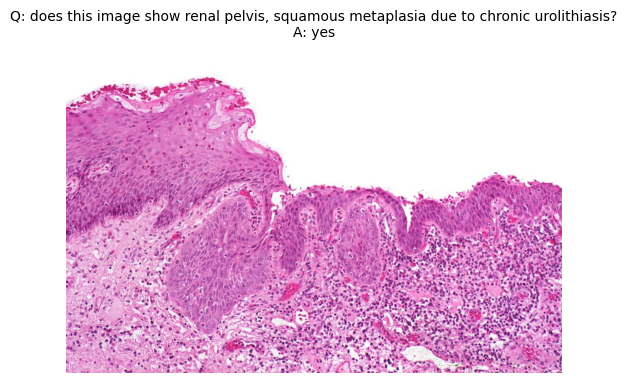

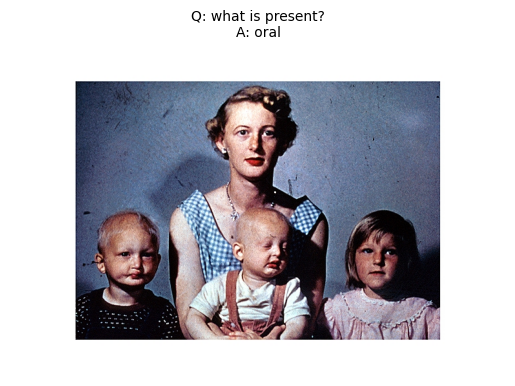

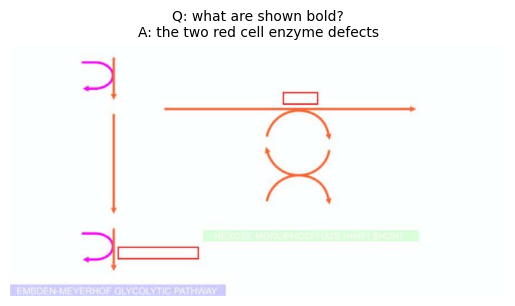

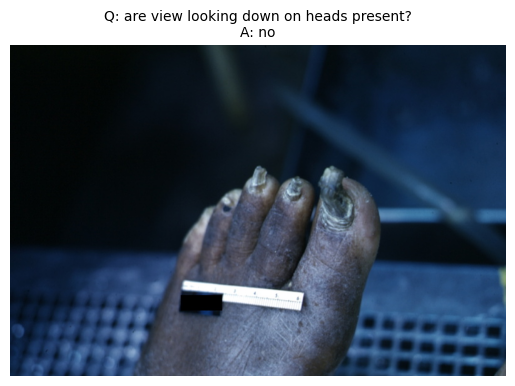

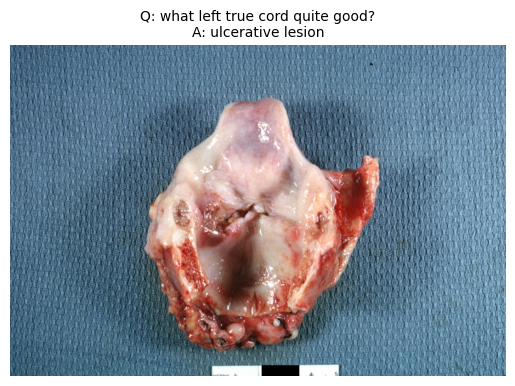

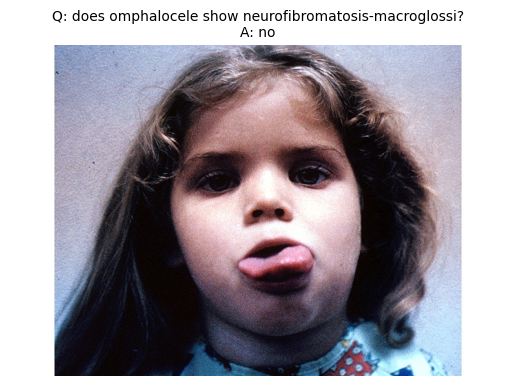

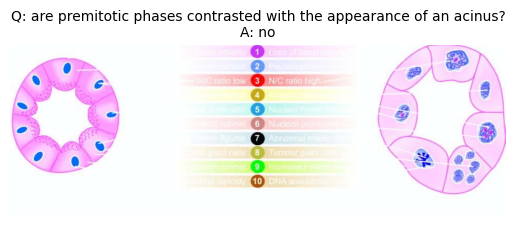

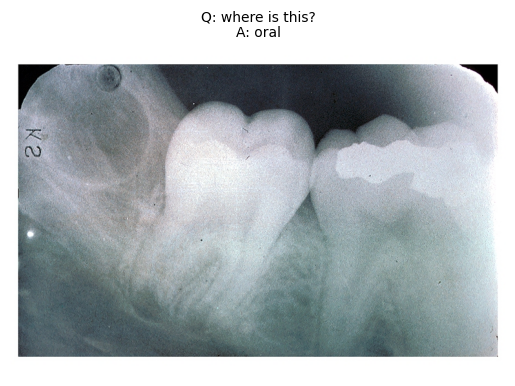

Starte die repräsentative Auswahl pro Fragetyp...
Für Fragetyp 'Where' wurden 1 Beispiele ausgewählt (von insgesamt 1315).
Für Fragetyp 'What' wurden 1 Beispiele ausgewählt (von insgesamt 8040).
Für Fragetyp 'Yes/No' wurden 1 Beispiele ausgewählt (von insgesamt 9728).
Für Fragetyp 'How' wurden 1 Beispiele ausgewählt (von insgesamt 427).
Für Fragetyp 'Why' wurden 1 Beispiele ausgewählt (von insgesamt 71).
Für Fragetyp 'Other' wurden 1 Beispiele ausgewählt (von insgesamt 41).
Für Fragetyp 'When' wurden 1 Beispiele ausgewählt (von insgesamt 30).
Für Fragetyp 'Who' wurden 1 Beispiele ausgewählt (von insgesamt 2).


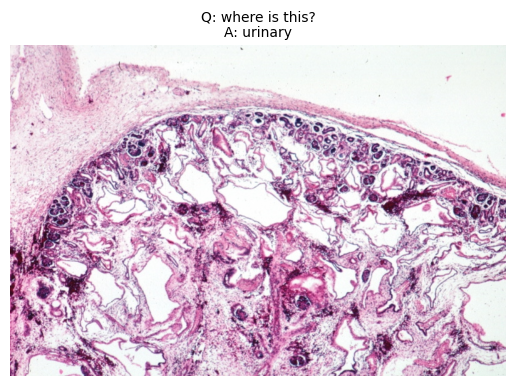

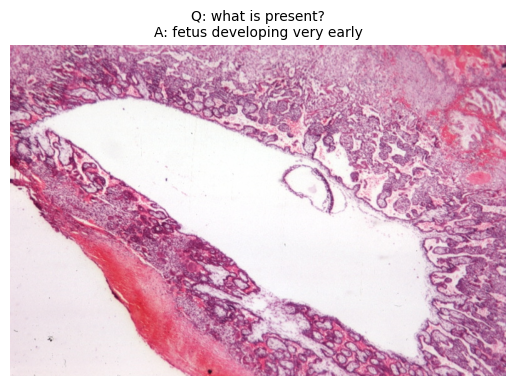

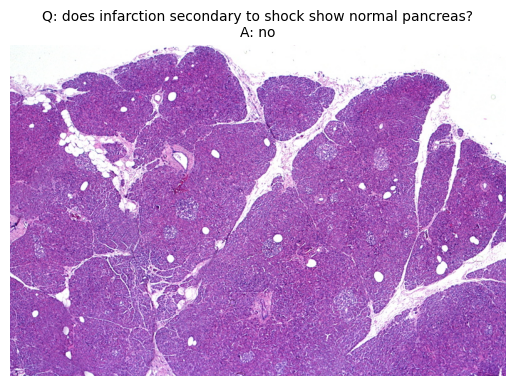

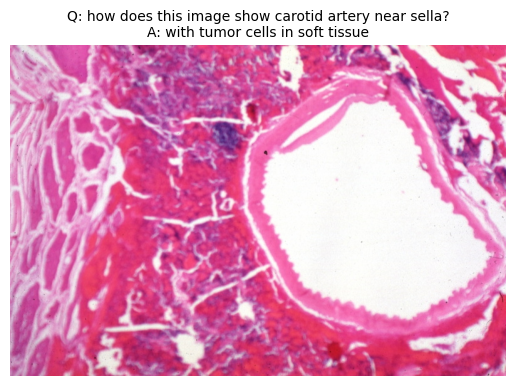

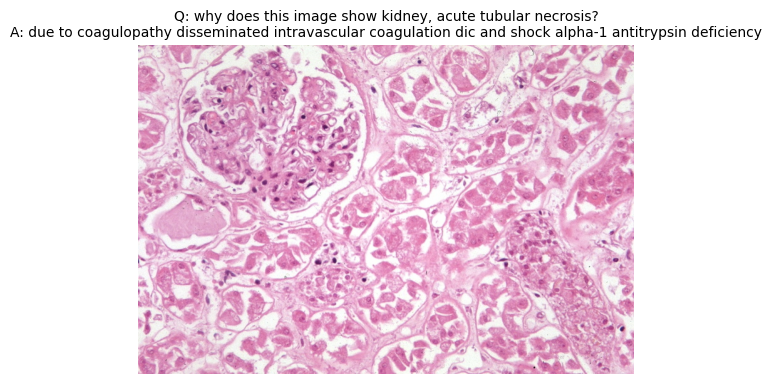

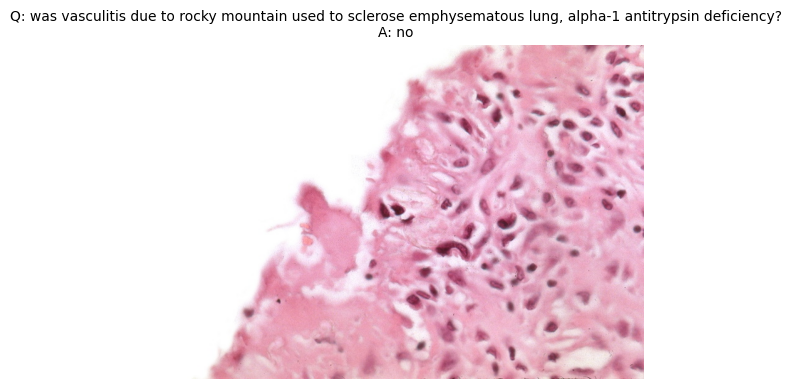

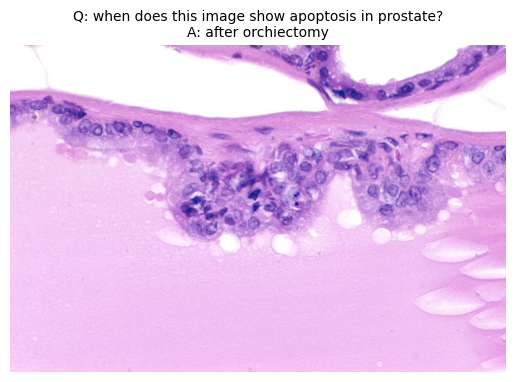

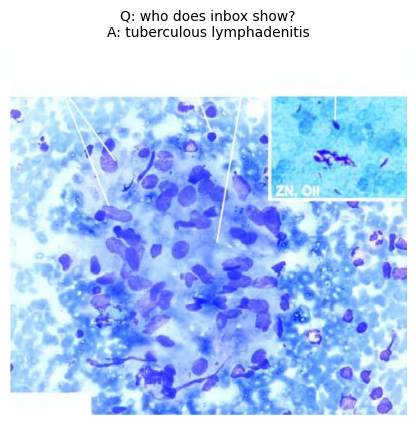

In [17]:
# Zelle 7: ausführen

project_root = Path.cwd().parent
data_path_train = project_root / "data" / "train"
dataset = load_from_disk(str(data_path_train))

# Beispiel: Sequenzielle Auswahl (SelfDis)
M = 8  # Anzahl der gewünschten Beispiele
print("Starte die sequenzielle Auswahl (SelfDis)...")
selected_indices = sequential_selfdis_selection(dataset, M)


for idx in selected_indices:
    sample = dataset[idx]
    plt.figure()
    plt.imshow(sample["image"])
    plt.axis("off")
    plt.title(f"Q: {sample['question']}\nA: {sample['answer']}", fontsize=10)
    plt.show()
    
print("-"*40)

# Beispiel: Repräsentative Auswahl pro Fragetyp
M_per_class = 1  # z. B. 1 Beispiel pro Fragetyp
print("Starte die repräsentative Auswahl pro Fragetyp...")
selected_repr_indices = representative_selection_by_question_type(dataset, M_per_class)

# Visualisiere die repräsentativ ausgewählten Beispiele
for idx in selected_repr_indices:
    sample = dataset[idx]
    plt.figure()
    plt.imshow(sample["image"])
    plt.axis("off")
    plt.title(f"Q: {sample['question']}\nA: {sample['answer']}", fontsize=10)
    plt.show()


In [13]:
len(selected_repr_indices)

16

In [14]:
len(selected_indices)

8

In [15]:
selected_indices

[8339, 7865, 16782, 10691, 6778, 9476, 9469, 8153]

In [27]:
selected_repr_indices

[10658,
 10652,
 18504,
 18508,
 8273,
 9066,
 16324,
 4151,
 10392,
 6178,
 9073,
 1847,
 4623,
 4613,
 10336,
 17755]